In [2]:
# default_exp launch

# Visualizing the SpaceX Tesla Roadster trip to Mars
Example taken from [poliastro docs](
https://hub.gke2.mybinder.org/user/poliastro-poliastro-4oek8xlv/notebooks/docs/source/examples/Visualizing%20the%20SpaceX%20Tesla%20Roadster%20trip%20to%20Mars.mystnb).

In [1]:
#!pip install rocketpy netCDF4

In [153]:
#export
import pandas as pd
import altair as alt
from pathlib import Path
import streamlit as st
from rocketpy import Environment, SolidMotor, Rocket, Flight

In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [47]:
# Creating an Environment for Starbase, Boca Chica
Env = Environment(
    railLength=5.2,
    latitude=25.996845, 
    longitude=-97.155086,
    elevation=0
) 

In [48]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12)) # Hour given in UTC time

In [49]:
Env.setAtmosphericModel(type='Forecast', file='GFS')

oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20211227/gfs_0p25_18z is not an available dataset"

Launch Site Details

Launch Rail Length:  5.2  m
Launch Date:  2021-12-28 12:00:00  UTC
Launch Site Latitude: 25.99685°
Launch Site Longitude: -97.15509°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 83931.49 W    2881954.92 N
Launch Site UTM zone: 15R
Launch Site Surface Elevation: 2.1 m


Atmospheric Model Details

Atmospheric Model Type:  Forecast
Forecast Maximum Height: 79.023 km
Forecast Time Period: From  2021-12-27 12:00:00  to  2022-01-12 12:00:00  UTC
Forecast Hour Interval:  3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 11.73 m/s
Surface Wind Direction: 167.90°
Surface Wind Heading: 347.90°
Surface Pressure: 1000.00 hPa
Surface Temperature: 296.30 K
Surface Air Density: 1.176 kg/m³
Surface Speed of Sound: 345.07 m/s


Atmospheric Model Plots


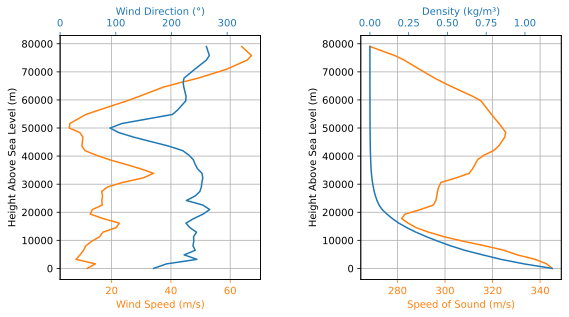

In [50]:
Env.info()

In [51]:
!wget https://raw.githubusercontent.com/Projeto-Jupiter/RocketPy/master/data/calisto/powerOffDragCurve.csv .
!wget https://raw.githubusercontent.com/Projeto-Jupiter/RocketPy/master/data/calisto/powerOnDragCurve.csv .

--2021-12-27 22:41:25--  https://raw.githubusercontent.com/Projeto-Jupiter/RocketPy/master/data/calisto/powerOffDragCurve.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3362 (3.3K) [text/plain]
Saving to: ‘powerOffDragCurve.csv.1’

powerOffDragCurve.c 100%[===================>]   3.28K  --.-KB/s    in 0s      

2021-12-27 22:41:25 (14.7 MB/s) - ‘powerOffDragCurve.csv.1’ saved [3362/3362]

--2021-12-27 22:41:25--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-12-27 22:41:25--
Total wall clock time: 0.2s
Downloaded: 1 files, 3.3K in 0s (14.7 MB/s)
--2021-12-27 22:41:26--  https://raw.githubusercontent.com/Projeto-Jupiter/RocketPy/master/data/calisto/powerOnDragCurve.csv
R

In [53]:
# Create Motor
Pro75M1670 = SolidMotor(
    thrustSource="Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5/1000,
    grainDensity=1815,
    grainOuterRadius=33/1000,
    grainInitialInnerRadius=15/1000,
    grainInitialHeight=120/1000,
    nozzleRadius=33/1000,
    throatRadius=11/1000,
    interpolationMethod='linear'
)


# Creating a Rocket
Calisto = Rocket(
    motor=Pro75M1670,
    radius=127/2000,
    mass=19.197-2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag='powerOffDragCurve.csv',
    powerOnDrag='powerOnDragCurve.csv'
)

Calisto.setRailButtons([0.2, -0.5])

NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)

Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

In [56]:
def drogueTrigger(p, y):
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    return True if y[5] < 0 and y[2] < 800 else False

Main = Calisto.addParachute('Main',
                            CdS=10.0,
                            trigger=mainTrigger, 
                            samplingRate=105,
                            lag=1.5,
                            noise=(0, 8.3, 0.5))

Drogue = Calisto.addParachute('Drogue',
                              CdS=1.0,
                              trigger=drogueTrigger, 
                              samplingRate=105,
                              lag=1.5,
                              noise=(0, 8.3, 0.5))

In [63]:
# or remove parachutes

Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)

## Launch Function

In [158]:
path = Path('.')
path / 'data'

PosixPath('data')

In [172]:
#export
def prepare_and_launch(datapath=''):
    
    # Creating an Environment for Starbase, Boca Chica
    Env = Environment(
        railLength=5.2,
        latitude=25.996845, 
        longitude=-97.155086,
        elevation=0
    ) 
    # Create Motor
    Pro75M1670 = SolidMotor(
        thrustSource=f"{datapath}Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5/1000,
        grainDensity=1815,
        grainOuterRadius=33/1000,
        grainInitialInnerRadius=15/1000,
        grainInitialHeight=120/1000,
        nozzleRadius=33/1000,
        throatRadius=11/1000,
        interpolationMethod='linear'
    )


    # Creating a Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127/2000,
        mass=19.197-2.956,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag=f"{datapath}powerOffDragCurve.csv",
        powerOnDrag=f"{datapath}powerOnDragCurve.csv")

    Calisto.setRailButtons([0.2, -0.5])

    NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

    FinSet = Calisto.addFins(4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)

    Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)
    
    # Simulate flight
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0)
    TestFlight.plotAttitudeData()
    return TestFlight



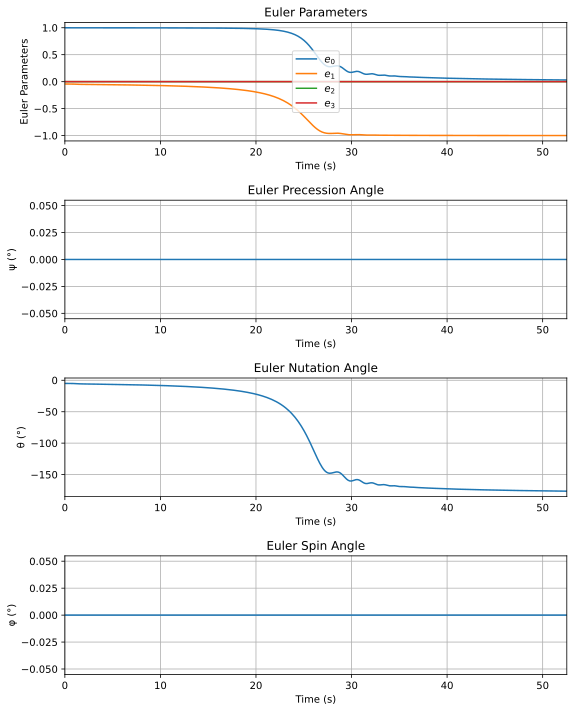

CPU times: user 1.42 s, sys: 78.1 ms, total: 1.5 s
Wall time: 1.34 s


In [174]:
%%time
TestFlight = prepare_and_launch(datapath='')

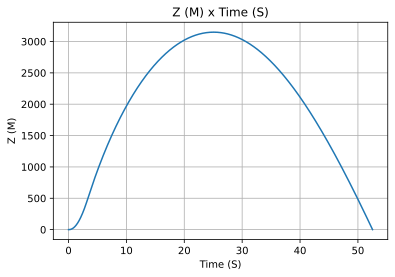

In [175]:
TestFlight.z()

In [168]:
df = pd.DataFrame(TestFlight.z[:, :], columns=['time', 'elevation'])
df['velocity_z'] = TestFlight.vz[:, 1]
df['x'] = TestFlight.x[:, 1]
df['y'] = TestFlight.y[:, 1]
df

,time,elevation,velocity_z,x,y
0,0.000000,0.000000,0.000000,0.0,0.000000
1,0.001410,0.000000,0.000000,0.0,0.000000
2,0.002819,0.000000,0.000000,0.0,0.000000
3,0.005639,0.000000,0.000000,0.0,0.000000
4,0.008458,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...
776,51.544881,190.501537,-192.386323,0.0,1007.933631
777,51.761379,148.778201,-193.048015,0.0,1010.614562
778,51.977877,106.913481,-193.693255,0.0,1013.275299
779,52.319749,40.525531,-194.678904,0.0,1017.435736


In [180]:
df.shape[1]

5

In [125]:
width, height = 400, 100
z = alt.Chart(df).mark_line().encode(
    x='time',
    y='elevation'
).properties(width=width, height=height)

In [126]:
vz = alt.Chart(df).mark_line().encode(
    x='time',
    y='velocity_z'
).properties(width=width, height=height)

In [127]:
z & vz

alt.VConcatChart(...)